# Index
[Bag Of Words](#bagofwords)

[Baseline Model](#baseline)

[K-Folds Cross-Validation](#kfolds)

[Over/Undersampling](#sampling)

[LSTM](#lstm)

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import ticker
import time
import math
import numpy as np
import random
import json

In [5]:
def load_data(path):
    # Load intents
    with open(path, 'r') as file:
        intents = json.load(file)['intents']

    intents_dict = {}
    response_dict = {}
    for intent in intents:
        intents_dict[intent['tag']] = intent['patterns']
        response_dict[intent['tag']] = intent['responses']

    return intents_dict, response_dict

In [8]:
intents_dict, response_dict = load_data('../clean_data/intents_enriched.json')
n_categories = len(intents_dict)
print(n_categories)

13


In [9]:
def process_intents(intents_dict):
    lemmatizer = WordNetLemmatizer()

    words = []
    intents = []
    words_tokenized = []
    ignore = ['?', '!', '.', ',']

    for intent in intents_dict:
        for pattern in intents_dict[intent]:
            w = nltk.tokenize.word_tokenize(pattern)
            words.extend(w) # append words from tokenized pattern to 'words'
            words_tokenized.append((w, intent)) # list of tuples containing list of words and intent class
            if intent not in intents:
                intents.append(intent) # unique list of intents

    # find base form of word and remove ignore words
    words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore]
    words = sorted(list(set(words))) # remove duplicates and sort

    intents = sorted(intents)

    return words, intents, words_tokenized

In [10]:
# full list of unique words, intents, and tokenized words, paired with their
# associated intent class
words, intents, words_tokenized = process_intents(intents_dict)

Bag of words approach

In [11]:
lemmatizer = WordNetLemmatizer()
features = []
labels = []

for pair in words_tokenized:
    words_encoded = []
    pattern_words = pair[0] # list of words
    # these words still need lemmatized
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    for w in words:
        # binary representation of whether each word is present in the pattern
        words_encoded.append(1 if w in pattern_words else 0)

    # make list of 0s with size = # of intents
    intents_encoded = [0] * len(intents)
    # set index of intent from sorted, unique list of intents to 1 in intents_encoded
    intents_encoded[intents.index(pair[1])] = 1 # pair[1] is the intent

    features.append(words_encoded)
    labels.append(intents_encoded)

# ensures compatibility with numpy-based ML frameworks and enables batch processing
features = np.array(features)
labels = np.array(labels)

[Back To Top](#index)
<a id='bagofwords'></a>

Baseline model

In [22]:
class RNN(nn.Module):
    name = "RNN" # for keeping track of model type
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
        # Check that input size matches expected size
        if input.size(1) != self.i2o.in_features - self.hidden_size:
            raise ValueError("Input size mismatch: expected {}, got {}".format(
                self.i2o.in_features - self.hidden_size, input.size(1)
            ))
        combined = torch.cat((input, hidden), 1)
        # Ensure combined size matches linear layer input
        if combined.size(1) != self.i2o.in_features:
            raise RuntimeError("Concatenated size mismatch: expected {}, got {}".format(
                self.i2o.in_features, combined.size(1)
            ))
        hidden = self.i2o(combined)
        hidden = self.ReLU(hidden)
        hidden = self.dropout(hidden)
        output = self.softmax(hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)


# n_hidden = 128
n_hidden = 256
rnn = RNN(len(words), n_hidden, len(intents))

<a id='baseline'></a>
[Back To Top](#index)

In [31]:
# from softmax layer outputs, find the most likely category
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # get the index of the greatest value
    category_i = top_i[0].item()
    return intents[category_i], category_i

('search_hospital_by_params', 9)


In [20]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

def train(model, category_tensor, line_tensor, criterion, optimizer):
    category_indices = category_tensor.argmax(dim=1)  # Convert to integer indices
    model.zero_grad()
    
    if model.name == "RNN":
        hidden = model.initHidden(line_tensor.size(0))
        output, _ = model(line_tensor, hidden)

    else:
        output = model(line_tensor)

    loss = criterion(output, category_indices)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    loss.backward()
    optimizer.step()
    return output, loss.item()

K-Folds Cross-Validation

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import torch.optim as optim
import torch.utils.data as data

def train_and_validate(features, labels, n_hidden, learning_rate, batch_size, n_iters, model_type):
    # Initialize KFold with 5 splits
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    # Store results
    fold_accuracies = []
    fold_losses = []

    # Tracking loss and accuracy during training
    train_accuracies = []

    input_size = len(features[0])
    output_size = len(labels[0]) # Number of intents

    for train_idx, test_idx in kf.split(features):
        # Create training and test datasets
        x_train = features[train_idx]
        y_train = labels[train_idx]
        x_test = features[test_idx]
        y_test = labels[test_idx]

        # Create DataLoaders for batching
        train_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train)), batch_size=batch_size, shuffle=True)
        test_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test)), batch_size=batch_size, shuffle=False)

        # Initialize a new model for each fold
        
        if model_type.name == "RNN":
            model = model_type(input_size, n_hidden, output_size)
        else:
            model = model_type(input_size, embedding_dim=100, hidden_dim=n_hidden, num_classes=output_size, dropout_rate=0.2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Reset loss tracking for each fold
        epoch_losses = []

        # Training loop for the current fold
        for epoch in range(n_iters):
            running_loss = 0.0
            correct = 0
            total = 0
            for line_tensor, category_tensor in train_loader:
                output, loss = train(model, category_tensor, line_tensor, criterion, optimizer)
                running_loss += loss  # Track total loss
                _, predicted = output.max(1)  # Get predictions
                total += category_tensor.size(0)  # Total samples
                correct += (predicted == category_tensor.argmax(dim=1)).sum().item()  # Correct predictions

            # Calculate average loss and accuracy for this epoch
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct / total

            # Store loss and accuracy
            epoch_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)

            if n_iters <= 10:
                print(f"Epoch {epoch + 1}/{n_iters}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%")
            elif epoch % 10 == 0:
                print(f"Epoch {epoch + 1}/{n_iters}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%")

        # Store results for this fold
        fold_losses.append(epoch_losses)

        # Evaluation and accuracy calculation for the current fold
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for line_tensor, category_tensor in test_loader:
                if model_type.name == "RNN":
                    hidden = model.initHidden(line_tensor.size(0))
                    output, hidden = model(line_tensor, hidden)
                else:
                    output = model(line_tensor)
                _, preds = output.max(1)  # Get predictions
                all_preds.extend(preds.numpy())
                all_targets.extend(category_tensor.numpy())
        
        # Calculate accuracy for this fold
        accuracy = accuracy_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds])
        fold_accuracies.append(accuracy)
        print(f"Final accuracy for this fold: {accuracy * 100:.2f}%")

    # Calculate the average accuracy across all folds
    average_accuracy = np.mean(fold_accuracies)
    print("Average accuracy across all folds:", average_accuracy)
    return model, average_accuracy, fold_losses

[Back To Top](#index)
<a id='kfolds'></a>

In [52]:
model, average_accuracy, fold_losses = train_and_validate(features, labels, n_hidden, learning_rate, 10, 100, RNN)

Epoch 1/100, Loss: 2.4411, Accuracy: 40.60%
Epoch 11/100, Loss: 1.6299, Accuracy: 48.83%
Epoch 21/100, Loss: 1.4342, Accuracy: 52.29%
Epoch 31/100, Loss: 1.3239, Accuracy: 60.40%
Epoch 41/100, Loss: 1.3293, Accuracy: 62.03%
Epoch 51/100, Loss: 1.2395, Accuracy: 64.67%
Epoch 61/100, Loss: 1.2215, Accuracy: 65.03%
Epoch 71/100, Loss: 1.1651, Accuracy: 66.97%
Epoch 81/100, Loss: 1.1543, Accuracy: 66.45%
Epoch 91/100, Loss: 1.1018, Accuracy: 67.88%
Final accuracy for this fold: 0.85%
Epoch 1/100, Loss: 2.4968, Accuracy: 24.83%
Epoch 11/100, Loss: 1.6769, Accuracy: 47.53%
Epoch 21/100, Loss: 1.5240, Accuracy: 51.11%
Epoch 31/100, Loss: 1.4526, Accuracy: 55.56%
Epoch 41/100, Loss: 1.3840, Accuracy: 58.22%
Epoch 51/100, Loss: 1.3397, Accuracy: 61.22%
Epoch 61/100, Loss: 1.2905, Accuracy: 63.61%
Epoch 71/100, Loss: 1.2558, Accuracy: 63.82%
Epoch 81/100, Loss: 1.2128, Accuracy: 65.82%
Epoch 91/100, Loss: 1.2107, Accuracy: 66.12%
Final accuracy for this fold: 0.48%
Epoch 1/100, Loss: 2.4426, Acc

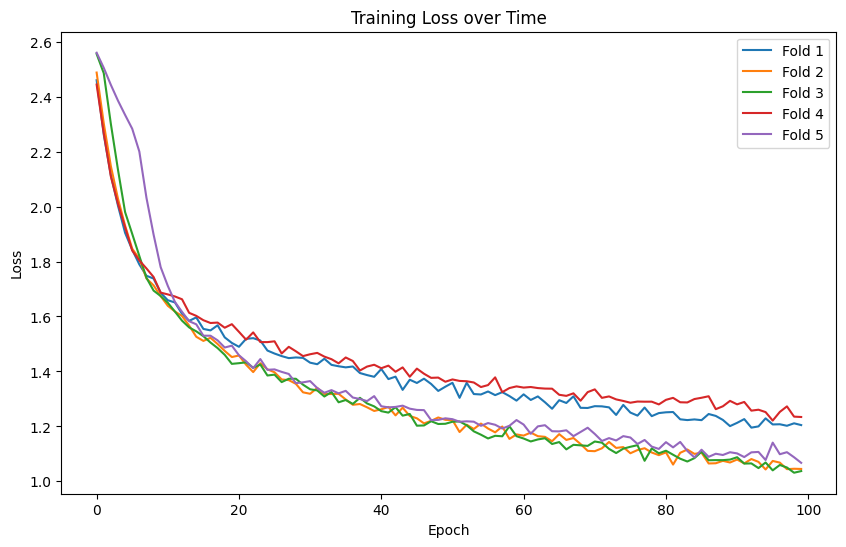

In [13]:
def plot_losses(fold_losses):
    plt.figure(figsize=(10, 6))  # Set the plot size
    for fold_idx, losses in enumerate(fold_losses):
        plt.plot(losses, label=f'Fold {fold_idx + 1}')  # Plot each fold's loss

    # Add titles and labels
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Time")
    plt.legend()  # Add a legend for the plot
    plt.show()  # Display the plot

plot_losses(fold_losses)

Massive class imbalance toward class 2 (blood_pressure_search) and 3 (goodbye)

In [17]:
from collections import Counter
import numpy as np

# Example: Convert one-hot encoded vectors to class indices
all_fold_distributions = []

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, test_idx in kf.split(features):
    # Convert one-hot encoded labels to class indices
    class_indices = np.argmax(labels[train_idx], axis=1)  # Convert to class indices
    
    # Calculate class distribution in the training set
    fold_train_classes = Counter(class_indices)  # Counter expects hashable types
    all_fold_distributions.append(fold_train_classes)

# Display class distributions for each fold
for fold_idx, distribution in enumerate(all_fold_distributions):
    print(f"Class distribution in fold {fold_idx + 1} (train):", distribution)

Class distribution in fold 1 (train): Counter({2: 1027, 3: 896, 1: 302, 8: 230, 12: 208, 11: 187, 7: 128, 6: 104, 5: 61, 10: 50, 4: 47, 0: 43, 9: 20})
Class distribution in fold 2 (train): Counter({2: 1000, 3: 895, 1: 320, 8: 230, 11: 203, 12: 200, 7: 118, 6: 99, 5: 66, 10: 54, 4: 48, 0: 46, 9: 24})
Class distribution in fold 3 (train): Counter({2: 1011, 3: 922, 1: 316, 8: 223, 11: 207, 12: 193, 7: 116, 6: 100, 5: 66, 10: 49, 4: 46, 0: 32, 9: 22})
Class distribution in fold 4 (train): Counter({2: 983, 3: 920, 1: 310, 8: 235, 12: 203, 11: 197, 7: 118, 6: 109, 5: 66, 10: 49, 4: 47, 0: 42, 9: 24})
Class distribution in fold 5 (train): Counter({2: 1019, 3: 887, 1: 316, 8: 234, 12: 208, 11: 206, 7: 120, 6: 100, 5: 65, 4: 52, 10: 38, 0: 37, 9: 22})


Using stratification to make distributions even across folds

In [18]:
from sklearn.model_selection import StratifiedKFold

# Initialize StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Example: Convert one-hot encoded vectors to class indices
all_fold_distributions = []
y_indices = np.argmax(labels, axis=1)

for train_idx, test_idx in skf.split(features, y_indices):
    # Convert one-hot encoded labels to class indices
    class_indices = np.argmax(labels[train_idx], axis=1)  # Convert to class indices
    
    # Calculate class distribution in the training set
    fold_train_classes = Counter(class_indices)  # Counter expects hashable types
    all_fold_distributions.append(fold_train_classes)

# Display class distributions for each fold
for fold_idx, distribution in enumerate(all_fold_distributions):
    print(f"Class distribution in fold {fold_idx + 1} using stratification (train):", distribution)

Class distribution in fold 1 using stratification (train): Counter({2: 1008, 3: 904, 1: 313, 8: 231, 12: 202, 11: 200, 7: 120, 6: 102, 5: 64, 4: 48, 10: 48, 0: 40, 9: 23})
Class distribution in fold 2 using stratification (train): Counter({2: 1008, 3: 904, 1: 312, 8: 231, 12: 202, 11: 200, 7: 120, 6: 103, 5: 65, 4: 48, 10: 48, 0: 40, 9: 22})
Class distribution in fold 3 using stratification (train): Counter({2: 1008, 3: 904, 1: 313, 8: 230, 12: 202, 11: 200, 7: 120, 6: 103, 5: 65, 4: 48, 10: 48, 0: 40, 9: 22})
Class distribution in fold 4 using stratification (train): Counter({2: 1008, 3: 904, 1: 313, 8: 230, 12: 203, 11: 200, 7: 120, 6: 102, 5: 65, 4: 48, 10: 48, 0: 40, 9: 22})
Class distribution in fold 5 using stratification (train): Counter({2: 1008, 3: 904, 1: 313, 8: 230, 12: 203, 11: 200, 7: 120, 6: 102, 5: 65, 4: 48, 10: 48, 0: 40, 9: 23})


In [19]:
# Store results
fold_accuracies = []
fold_losses = []

# Tracking loss and accuracy during training
train_losses = []
train_accuracies = []

input_size = len(features[0])
output_size = len(labels[0]) # Number of intents
n_iters = 100

y_indices = np.argmax(labels, axis=1)

for train_idx, test_idx in skf.split(features, y_indices):
    # Create training and test datasets
    x_train = features[train_idx]
    y_train = labels[train_idx]
    x_test = features[test_idx]
    y_test = labels[test_idx]

    # Create DataLoaders for batching
    train_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train)), batch_size=10, shuffle=True)
    test_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test)), batch_size=10, shuffle=False)

    # Initialize a new model for each fold
    
    model = RNN(input_size, n_hidden, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Reset loss tracking for each fold
    epoch_losses = []

    # Training loop for the current fold
    for epoch in range(n_iters):
        running_loss = 0.0
        correct = 0
        total = 0
        for line_tensor, category_tensor in train_loader:
            output, loss = train(model, category_tensor, line_tensor, criterion, optimizer)
            running_loss += loss  # Track total loss
            _, predicted = output.max(1)  # Get predictions
            total += category_tensor.size(0)  # Total samples
            correct += (predicted == category_tensor.argmax(dim=1)).sum().item()  # Correct predictions

        # Calculate average loss and accuracy for this epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        # Store loss and accuracy
        epoch_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{n_iters}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%")

    # Store results for this fold
    fold_losses.append(epoch_losses)

    # Evaluation and accuracy calculation for the current fold
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for line_tensor, category_tensor in test_loader:
            hidden = model.initHidden(line_tensor.size(0))
            output, hidden = model(line_tensor, hidden)
            _, preds = output.max(1)  # Get predictions
            all_preds.extend(preds.numpy())
            all_targets.extend(category_tensor.numpy())
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score([np.argmax(y) for y in all_targets], [np.argmax(p) for p in all_preds])
    fold_accuracies.append(accuracy)
    print(f"Final accuracy for this fold: {accuracy * 100:.2f}%")

# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print("Average accuracy across all folds:", average_accuracy)

Epoch 1/100, Loss: 2.4677, Accuracy: 33.67%
Epoch 11/100, Loss: 1.6611, Accuracy: 47.87%
Epoch 21/100, Loss: 1.4740, Accuracy: 50.86%
Epoch 31/100, Loss: 1.3751, Accuracy: 58.25%
Epoch 41/100, Loss: 1.3065, Accuracy: 61.64%


KeyboardInterrupt: 

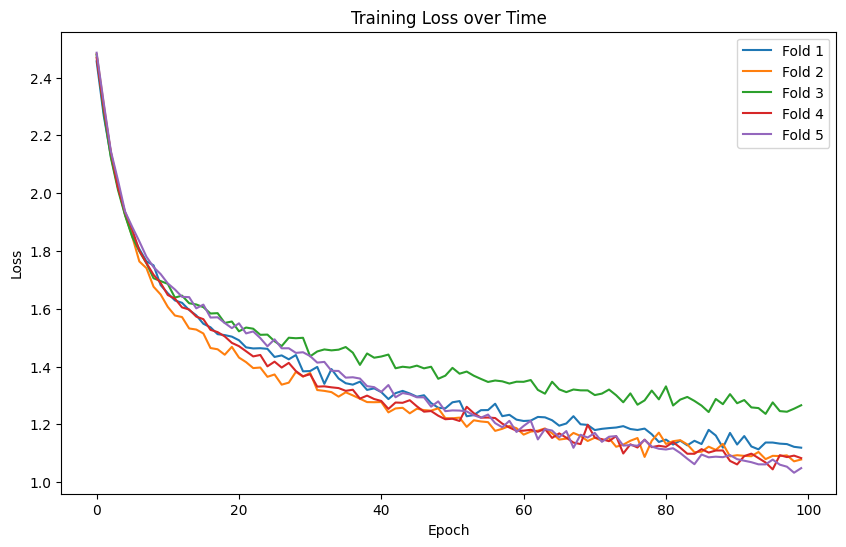

In [110]:
plot_losses(fold_losses)

Evening out distribution by oversampling

In [20]:
from imblearn.over_sampling import RandomOverSampler

# Oversample minority classes
ros = RandomOverSampler(random_state=1)
features_oversampled, labels_oversampled = ros.fit_resample(features, labels)

# Example: Convert one-hot encoded vectors to class indices
all_fold_distributions = []

for train_idx, test_idx in kf.split(features_oversampled):
    # Convert one-hot encoded labels to class indices
    class_indices = np.argmax(labels_oversampled[train_idx], axis=1)  # Convert to class indices
    
    # Calculate class distribution in the training set
    fold_train_classes = Counter(class_indices)  # Counter expects hashable types
    all_fold_distributions.append(fold_train_classes)

# Display class distributions for each fold
for fold_idx, distribution in enumerate(all_fold_distributions):
    print(f"Class distribution resampled in fold {fold_idx + 1} (train):", distribution)

Class distribution resampled in fold 1 (train): Counter({12: 1031, 5: 1028, 4: 1019, 10: 1017, 6: 1016, 1: 1012, 11: 1008, 2: 1006, 3: 1001, 8: 1001, 0: 997, 9: 993, 7: 975})
Class distribution resampled in fold 2 (train): Counter({7: 1029, 4: 1022, 6: 1020, 3: 1014, 2: 1011, 10: 1008, 12: 1006, 8: 1005, 0: 1004, 5: 1004, 11: 996, 1: 993, 9: 992})
Class distribution resampled in fold 3 (train): Counter({12: 1026, 8: 1025, 5: 1024, 4: 1020, 9: 1020, 1: 1019, 11: 1008, 6: 1000, 7: 1000, 3: 999, 0: 998, 2: 987, 10: 978})
Class distribution resampled in fold 4 (train): Counter({2: 1032, 0: 1027, 7: 1027, 3: 1018, 11: 1017, 9: 1010, 1: 1002, 8: 1002, 10: 1000, 6: 997, 12: 992, 5: 992, 4: 988})
Class distribution resampled in fold 5 (train): Counter({10: 1037, 9: 1025, 0: 1014, 1: 1014, 11: 1011, 7: 1009, 3: 1008, 6: 1007, 8: 1007, 2: 1004, 5: 992, 4: 991, 12: 985})


[Back To Top](#index)
<a id='sampling'></a>

Oversampling provides a marked improvement to model test accuracy

In [21]:
model, average_accuracy, fold_losses = train_and_validate(features_oversampled, labels_oversampled, n_hidden, learning_rate, 10, 100, RNN)

Epoch 1/100, Loss: 2.5149, Accuracy: 25.99%
Epoch 11/100, Loss: 1.7819, Accuracy: 61.00%
Epoch 21/100, Loss: 1.4997, Accuracy: 62.81%
Epoch 31/100, Loss: 1.3614, Accuracy: 63.47%
Epoch 41/100, Loss: 1.2864, Accuracy: 63.53%
Epoch 51/100, Loss: 1.2327, Accuracy: 63.44%
Epoch 61/100, Loss: 1.1887, Accuracy: 63.63%
Epoch 71/100, Loss: 1.1754, Accuracy: 63.06%
Epoch 81/100, Loss: 1.1399, Accuracy: 63.56%
Epoch 91/100, Loss: 1.1398, Accuracy: 63.00%
Final accuracy for this fold: 8.03%
Epoch 1/100, Loss: 2.5377, Accuracy: 21.51%
Epoch 11/100, Loss: 1.6906, Accuracy: 68.46%
Epoch 21/100, Loss: 1.3152, Accuracy: 71.85%
Epoch 31/100, Loss: 1.1613, Accuracy: 72.72%
Epoch 41/100, Loss: 1.0730, Accuracy: 73.01%
Epoch 51/100, Loss: 0.9895, Accuracy: 73.76%
Epoch 61/100, Loss: 0.9547, Accuracy: 73.66%
Epoch 71/100, Loss: 0.9119, Accuracy: 74.08%
Epoch 81/100, Loss: 0.8985, Accuracy: 74.29%
Epoch 91/100, Loss: 0.8705, Accuracy: 74.84%
Final accuracy for this fold: 7.81%
Epoch 1/100, Loss: 2.5342, Acc

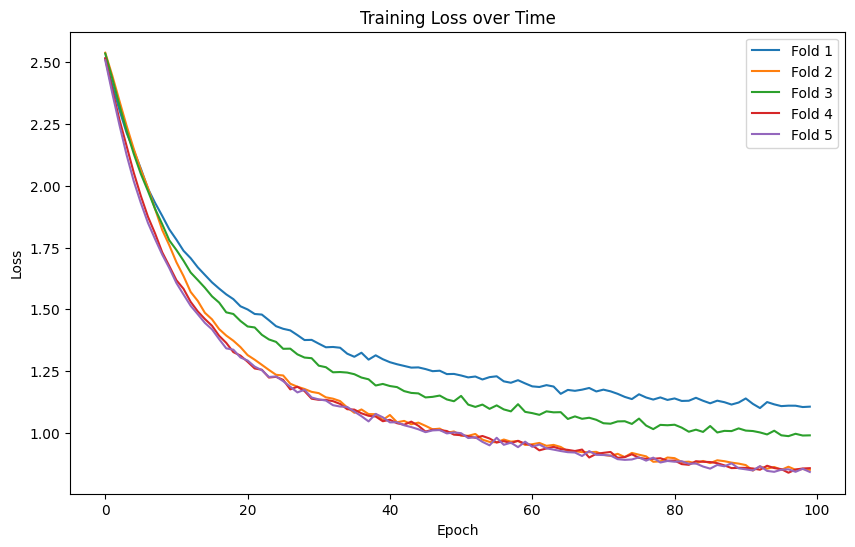

In [22]:
plot_losses(fold_losses)

In [23]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample majority classes
rus = RandomUnderSampler(random_state=1)
features_undersampled, labels_undersampled = rus.fit_resample(features, labels)

# Example: Convert one-hot encoded vectors to class indices
all_fold_distributions = []

for train_idx, test_idx in kf.split(features_undersampled):
    # Convert one-hot encoded labels to class indices
    class_indices = np.argmax(labels_undersampled[train_idx], axis=1)  # Convert to class indices
    
    # Calculate class distribution in the training set
    fold_train_classes = Counter(class_indices)  # Counter expects hashable types
    all_fold_distributions.append(fold_train_classes)

# Display class distributions for each fold
for fold_idx, distribution in enumerate(all_fold_distributions):
    print(f"Class distribution undersampled in fold {fold_idx + 1} (train):", distribution)

Class distribution undersampled in fold 1 (train): Counter({1: 27, 2: 23, 5: 23, 6: 23, 7: 23, 12: 23, 3: 22, 9: 22, 10: 22, 11: 22, 8: 21, 0: 20, 4: 20})
Class distribution undersampled in fold 2 (train): Counter({9: 25, 11: 24, 2: 23, 4: 23, 7: 23, 8: 23, 0: 22, 1: 22, 6: 22, 10: 22, 12: 22, 5: 21, 3: 19})
Class distribution undersampled in fold 3 (train): Counter({3: 25, 5: 25, 11: 25, 0: 24, 8: 24, 9: 24, 2: 23, 4: 22, 10: 22, 6: 21, 7: 21, 12: 20, 1: 15})
Class distribution undersampled in fold 4 (train): Counter({0: 25, 1: 25, 4: 25, 10: 24, 12: 24, 3: 22, 5: 22, 7: 22, 2: 21, 8: 21, 9: 21, 6: 20, 11: 19})
Class distribution undersampled in fold 5 (train): Counter({6: 26, 3: 24, 1: 23, 7: 23, 8: 23, 12: 23, 2: 22, 4: 22, 10: 22, 11: 22, 0: 21, 5: 21, 9: 20})


Likewise, undersampling seems to improve model performance by about 6%

In [24]:
train_and_validate(features_undersampled, labels_undersampled, n_hidden, learning_rate, 10, 100, RNN)

Epoch 1/100, Loss: 2.5704, Accuracy: 7.56%
Epoch 11/100, Loss: 2.5467, Accuracy: 18.21%
Epoch 21/100, Loss: 2.5308, Accuracy: 27.15%
Epoch 31/100, Loss: 2.5093, Accuracy: 31.96%
Epoch 41/100, Loss: 2.4830, Accuracy: 33.68%
Epoch 51/100, Loss: 2.4605, Accuracy: 38.49%
Epoch 61/100, Loss: 2.4028, Accuracy: 43.64%
Epoch 71/100, Loss: 2.4013, Accuracy: 41.24%
Epoch 81/100, Loss: 2.3706, Accuracy: 45.36%
Epoch 91/100, Loss: 2.3297, Accuracy: 46.05%
Final accuracy for this fold: 10.96%
Epoch 1/100, Loss: 2.5660, Accuracy: 7.22%
Epoch 11/100, Loss: 2.5443, Accuracy: 18.90%
Epoch 21/100, Loss: 2.5108, Accuracy: 31.27%
Epoch 31/100, Loss: 2.4829, Accuracy: 38.83%
Epoch 41/100, Loss: 2.4485, Accuracy: 46.74%
Epoch 51/100, Loss: 2.4164, Accuracy: 51.89%
Epoch 61/100, Loss: 2.3842, Accuracy: 52.92%
Epoch 71/100, Loss: 2.3520, Accuracy: 56.36%
Epoch 81/100, Loss: 2.3169, Accuracy: 57.73%
Epoch 91/100, Loss: 2.2935, Accuracy: 56.70%
Final accuracy for this fold: 8.22%
Epoch 1/100, Loss: 2.5633, Accu

(RNN(
   (i2o): Linear(in_features=701, out_features=13, bias=True)
   (softmax): LogSoftmax(dim=1)
   (ReLU): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
 ),
 0.07697869101978691,
 [[2.5704025745391847,
   2.5656604766845703,
   2.567523407936096,
   2.5658938884735107,
   2.5614497979482014,
   2.5608075618743897,
   2.5559226274490356,
   2.5559945344924926,
   2.556129288673401,
   2.556358559926351,
   2.54668169816335,
   2.5514063119888304,
   2.5490339438120526,
   2.5432358185450235,
   2.539065440495809,
   2.5346259832382203,
   2.5398667017618815,
   2.5372438430786133,
   2.5338653087615968,
   2.527334189414978,
   2.5307677427927655,
   2.5300147851308186,
   2.526296790440877,
   2.5267615000406902,
   2.518779444694519,
   2.5139054536819456,
   2.520509608586629,
   2.518509880701701,
   2.517479904492696,
   2.503711533546448,
   2.5092671473821,
   2.4977205276489256,
   2.509977904955546,
   2.507171932856242,
   2.5004544973373415,
   2.500825587908427,
   

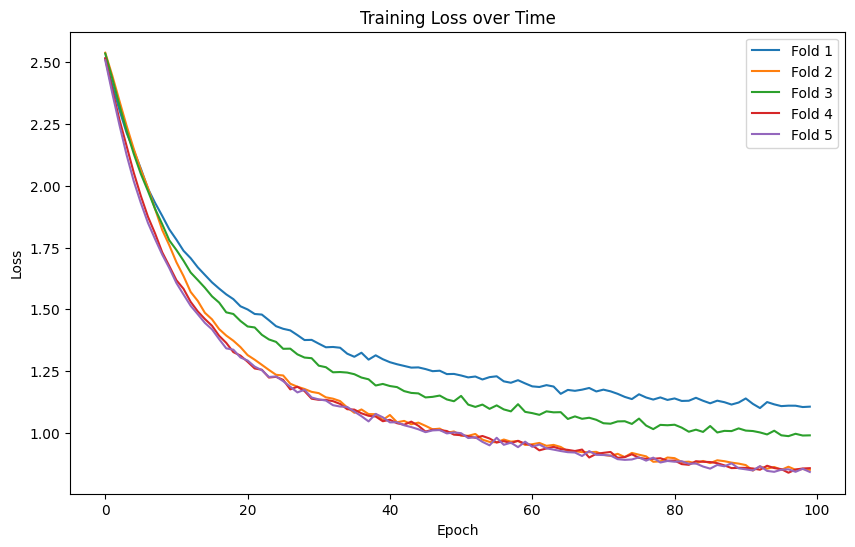

In [25]:
plot_losses(fold_losses)

Increase layer depth

In [53]:
class Model_2(nn.Module):
    name = "RNN"
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_2, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.ReLU(hidden)
        hidden = self.dropout(hidden)
        output = self.h2o(hidden)
        output = self.ReLU(output)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [27]:
model_2, average_accuracy, fold_losses = train_and_validate(features, labels, n_hidden, learning_rate, 10, 100, Model_2)

Epoch 1/100, Loss: 2.5613, Accuracy: 10.75%
Epoch 11/100, Loss: 1.9063, Accuracy: 46.53%
Epoch 21/100, Loss: 1.5959, Accuracy: 47.44%
Epoch 31/100, Loss: 1.5422, Accuracy: 47.26%
Epoch 41/100, Loss: 1.4949, Accuracy: 47.68%
Epoch 51/100, Loss: 1.4505, Accuracy: 50.68%
Epoch 61/100, Loss: 1.4203, Accuracy: 52.68%
Epoch 71/100, Loss: 1.3894, Accuracy: 53.98%
Epoch 81/100, Loss: 1.3241, Accuracy: 55.68%
Epoch 91/100, Loss: 1.3147, Accuracy: 55.53%
Final accuracy for this fold: 0.85%
Epoch 1/100, Loss: 2.5548, Accuracy: 18.92%
Epoch 11/100, Loss: 1.8105, Accuracy: 46.17%
Epoch 21/100, Loss: 1.5604, Accuracy: 47.47%
Epoch 31/100, Loss: 1.4788, Accuracy: 48.96%
Epoch 41/100, Loss: 1.3804, Accuracy: 55.13%
Epoch 51/100, Loss: 1.3415, Accuracy: 58.70%
Epoch 61/100, Loss: 1.2435, Accuracy: 63.55%
Epoch 71/100, Loss: 1.2070, Accuracy: 65.82%
Epoch 81/100, Loss: 1.1554, Accuracy: 66.42%
Epoch 91/100, Loss: 1.1233, Accuracy: 66.45%
Final accuracy for this fold: 0.48%
Epoch 1/100, Loss: 2.5722, Acc

Increasing layer depth seems to offer no improvement to model performance

In [28]:
train_and_validate(features_oversampled, labels_oversampled, n_hidden, learning_rate, 10, 100, Model_2)

Epoch 1/100, Loss: 2.5642, Accuracy: 8.33%
Epoch 11/100, Loss: 2.4052, Accuracy: 33.59%
Epoch 21/100, Loss: 2.0604, Accuracy: 33.73%
Epoch 31/100, Loss: 1.9207, Accuracy: 34.95%
Epoch 41/100, Loss: 1.7759, Accuracy: 40.62%
Epoch 51/100, Loss: 1.6310, Accuracy: 45.99%
Epoch 61/100, Loss: 1.5390, Accuracy: 46.73%
Epoch 71/100, Loss: 1.4309, Accuracy: 53.14%
Epoch 81/100, Loss: 1.3408, Accuracy: 53.81%
Epoch 91/100, Loss: 1.3050, Accuracy: 54.65%
Final accuracy for this fold: 8.03%
Epoch 1/100, Loss: 2.5582, Accuracy: 13.93%
Epoch 11/100, Loss: 2.1039, Accuracy: 42.80%
Epoch 21/100, Loss: 1.6545, Accuracy: 55.14%
Epoch 31/100, Loss: 1.4648, Accuracy: 55.75%
Epoch 41/100, Loss: 1.3300, Accuracy: 58.90%
Epoch 51/100, Loss: 1.2402, Accuracy: 62.57%
Epoch 61/100, Loss: 1.2033, Accuracy: 63.61%
Epoch 71/100, Loss: 1.1828, Accuracy: 64.58%
Epoch 81/100, Loss: 1.1500, Accuracy: 66.35%
Epoch 91/100, Loss: 1.1409, Accuracy: 66.51%
Final accuracy for this fold: 7.81%
Epoch 1/100, Loss: 2.5584, Accu

(Model_2(
   (i2h): Linear(in_features=701, out_features=256, bias=True)
   (h2o): Linear(in_features=256, out_features=13, bias=True)
   (softmax): LogSoftmax(dim=1)
   (ReLU): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
 ),
 0.07692307692307693,
 [[2.5642458605093412,
   2.5586117759722047,
   2.551421936916814,
   2.5440796734630196,
   2.5335343702434128,
   2.5209471548358326,
   2.505433954599702,
   2.48708641010782,
   2.4638844762113967,
   2.4372288640631146,
   2.405200682006475,
   2.3725551466829082,
   2.332358684274279,
   2.290431839468641,
   2.2494901122253963,
   2.2124912714248937,
   2.1760004301456712,
   2.143646596862013,
   2.1132726285586734,
   2.0868527619189474,
   2.060388017755533,
   2.044213808464877,
   2.017592764282663,
   2.0125510399801687,
   1.9903006884180618,
   1.9798815417253361,
   1.9631691502760968,
   1.9566071605427768,
   1.9403146485805876,
   1.9409735433751623,
   1.9206796082988393,
   1.9112466224543836,
   1.904586868509820

Try different model type

In [15]:
class IntentClassifier(nn.Module):
    name = "LSTM"
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout_rate=0.5):
        super(IntentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Multiply by 2 because of bidirectional LSTM
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        # Take the last output from the LSTM (for classification)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        return self.softmax(out)

[Back To Top](#index)
<a id='lstm'></a>

In [30]:
n_hidden = 128 # reduced hidden size to reduce train time
learning_rate = 0.01 # likewise, increased learning rate
model_lstm, average_accuracy, fold_losses = train_and_validate(features, labels, n_hidden, learning_rate, 10, 10, IntentClassifier)

Epoch 1/10, Loss: 2.5500, Accuracy: 24.86%
Epoch 2/10, Loss: 2.4504, Accuracy: 31.09%
Epoch 3/10, Loss: 2.3856, Accuracy: 31.09%
Epoch 4/10, Loss: 2.3787, Accuracy: 31.09%
Epoch 5/10, Loss: 2.3742, Accuracy: 31.09%
Epoch 6/10, Loss: 2.3681, Accuracy: 31.09%
Epoch 7/10, Loss: 2.3543, Accuracy: 31.30%
Epoch 8/10, Loss: 2.3281, Accuracy: 38.75%
Epoch 9/10, Loss: 2.2900, Accuracy: 46.68%
Epoch 10/10, Loss: 2.2594, Accuracy: 46.87%
Final accuracy for this fold: 0.85%
Epoch 1/10, Loss: 2.5506, Accuracy: 23.95%
Epoch 2/10, Loss: 2.4778, Accuracy: 30.28%
Epoch 3/10, Loss: 2.3950, Accuracy: 30.28%
Epoch 4/10, Loss: 2.3829, Accuracy: 30.28%


KeyboardInterrupt: 